# Imports

In [121]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn import preprocessing, compose, pipeline, model_selection, neural_network, metrics, tree, ensemble, decomposition, cluster, impute, linear_model, neighbors, mixture, feature_selection
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection._split import check_array
import seaborn as sns
from itertools import product
from IPython.display import Markdown, Latex
# import mlines
import matplotlib.lines as mlines

## Definitions

In [122]:
class ArbitraryStratifiedKFold(model_selection.StratifiedKFold):
    def __init__(self, n_splits=5, *, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def split(self, X, y, groups=None):
        if groups is None:
            groups = y
        groups = check_array(groups, input_name="y", ensure_2d=False, dtype=None)
        return super().split(X, groups, groups)


def getDataset(df):
    df = df.copy()
    df.columns = df.iloc[0].str.strip().str.replace("  ", " ")
    dfc = df.iloc[3:, [3, 4, 6, 7, 8, 35]].copy().astype(float)
    unitless = df.iloc[3:, [20, 24, 26, 28, 30]].copy().astype(float)
    a = pd.DataFrame(dfc.iloc[:, :5].values, columns=pd.MultiIndex.from_product([['Input Raw'], dfc.columns[:5]]))
    b = pd.DataFrame(unitless.values, columns=pd.MultiIndex.from_product([['Input Calculated'], unitless.columns]))
    c = pd.DataFrame(dfc.iloc[:, [-1]].values, columns=pd.MultiIndex.from_product([['Output'], dfc.columns[[-1]]]))
    d = pd.concat([a, b, c], axis=1)
    # compress multiindex
    e = d.copy()
    # e.columns = ['_'.join(col).strip() for col in e.columns.values]
    return e


class LocallyWeightedRegressor(neighbors.KNeighborsRegressor):
    def __init__(self, n_neighbors=2, gamma=None):
        super().__init__(n_neighbors=n_neighbors)
        if gamma is None:
            gamma = 1.0
        self.gamma = gamma

    def predict(self, X):
        y_preds = []
        dist, inds = self.kneighbors(X)
        for i in range(X.shape[0]):
            model_ftp = linear_model.LinearRegression()
            weights = np.exp(-self.gamma * dist[i])
            model_ftp.fit(self._fit_X[inds[i]], self._y[inds[i]], sample_weight=weights)
            y_preds.append(model_ftp.predict(X[i:i+1]))
        res = np.array(y_preds).squeeze()
        if res.ndim == 0:
            res = res.reshape(-1, 1)
        return res
    
    
def pearson(y_true, y_pred):
    def ms(x):
        return x - x.mean()
    a = ms(y_true)
    b = ms(y_pred)
    s = (a * b).sum()**2 / (a**2).sum() / (b**2).sum()
    return float(np.array(s).squeeze())


def bias(y_true, y_pred):
    return (-y_true + y_pred).sum() / y_true.sum()

def renameScores(x):
    return x.replace("test_", "Test ").replace("train_", "Train ")

# Read data

In [123]:
datasets = {}
datasets['duz boru h'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz boru H ", header=None)
datasets['mikrokanatli boru h'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru H")
datasets['duz boru dp'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz Boru dP")
datasets['mikrokanatli boru dp'] = pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru dP")

datasets_processed = {}
datasets_processed['duz boru h'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz boru H ", header=None))
datasets_processed['mikrokanatli boru h'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru H", header=None))
datasets_processed['duz boru dp'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Düz Boru dP", header=None))
datasets_processed['mikrokanatli boru dp'] = getDataset(pd.read_excel("../data/Boiling ANN data.xlsx", sheet_name="Mikrokanatlı Boru dP", header=None))

data_h = pd.concat([
    datasets_processed['duz boru h'].assign(dataset='Plain tube h'),
    datasets_processed['mikrokanatli boru h'].assign(dataset='Microfin tube h')
], axis=0, ignore_index=True)


data_dp = pd.concat([
    datasets_processed['duz boru dp'].assign(dataset='Plain tube dp'),
    datasets_processed['mikrokanatli boru dp'].assign(dataset='Microfin tube dp')
], axis=0, ignore_index=True)



data_h.to_pickle("../data/Boiling ANN data_h.pkl")
data_dp.to_pickle("../data/Boiling ANN data_dp.pkl")

In [124]:
idx = pd.IndexSlice

In [125]:
Xh, yh = data_h.loc[:, idx[['Input Raw', 'Input Calculated'], :]], data_h['Output']
Xdp, ydp = data_dp.loc[:, idx[['Input Raw', 'Input Calculated'], :]], data_dp['Output']
pd.DataFrame(Xh).assign(y=yh).to_csv("../data/Boiling_ANN_data_h.csv", index=False)
pd.DataFrame(Xdp).assign(y=ydp).to_csv("../data/Boiling_ANN_data_dp.csv", index=False)

In [126]:
NAME_KEYS = {
    "Mass flux": "$G$",
    "Saturation pressure": "$P_{sat}$",
    "Heat flux": "$q$",
    "Quality": "$x$",
    "Pressure drop": "$\Delta P_{sat}$",
    "Reynolds number": "$Re_{t}$",
    "Two-phase multiplier": "$X_{tt}$",
    "Froude number": "$Fr_{l}$",
    "Weber number": "$We_{L}$",
    "Bond number": "$Bo$",
    "Heat transfer coefficient": "$h_{TP}$"
}

In [127]:
# Rename using definitions in the markdown

data_h.T.drop(("Output", "Output 1")).reset_index(drop=True).rename(
    index={
        0: 'Mass flux',
        1: 'Saturation pressure',
        2: 'Heat flux',
        3: 'Quality',
        4: 'Pressure drop',
        # 5: 'Heat transfer coefficient',
        5: 'Reynolds number',
        6: 'Two-phase multiplier',
        7: 'Froude number',
        8: 'Weber number',
        9: 'Bond number',
        10: "Tube type"
    },
).T.assign(y=yh).rename(columns={'y': 'Heat transfer coefficient'}).sample(5).head().style.set_caption("Microfinned and Plain Tubes - h")


,Mass flux,Saturation pressure,Heat flux,Quality,Pressure drop,Reynolds number,Two-phase multiplier,Froude number,Weber number,Bond number,Tube type,Heat transfer coefficient
153,385.547690,607890.000000,15000.000000,0.549632,20146.000000,7284.584299,0.173417,1.184910,123.996780,0.132792,Microfin tube h,5933.165180
73,199.913617,475629.216029,14702.221998,0.732612,5490.640696,2033.264849,0.074233,0.304273,28.929657,0.060847,Plain tube h,4052.769229
12,290.350729,590592.902174,10290.371384,0.568620,6493.000000,5192.706867,0.159495,0.668163,69.079721,0.122886,Plain tube h,4352.184114
152,380.787842,607890.000000,15000.000000,0.501691,18868.000000,7960.498354,0.206206,1.155834,120.954031,0.154890,Microfin tube h,5956.838206
44,190.393921,590804.772181,14665.173139,0.440756,3166.860816,4414.971989,0.253434,0.287352,29.711675,0.185476,Plain tube h,3785.730964


In [128]:
# Rename using definitions in the markdown

data_dp.T.drop(("Output", "Output 1")).reset_index(drop=True).rename(
    index={
        0: 'Mass flux',
        1: 'Saturation pressure',
        2: 'Heat flux',
        3: 'Quality',
        # 4: 'Pressure drop',
        4: 'Heat transfer coefficient',
        5: 'Reynolds number',
        6: 'Two-phase multiplier',
        7: 'Froude number',
        8: 'Weber number',
        9: 'Bond number',
        10: "Tube type"
    },
).T.assign(y=ydp).rename(columns={'y': 'Pressure drop'}).sample(5).head().style.set_caption("Microfinned and Plain Tubes - $\Delta P$")


,Mass flux,Saturation pressure,Heat flux,Quality,Heat transfer coefficient,Reynolds number,Two-phase multiplier,Froude number,Weber number,Bond number,Tube type,Pressure drop
159,185.634073,488370.000000,15000.000000,0.552524,5316.385315,3192.310540,0.154071,0.263583,25.303465,0.116771,Microfin tube dp,5987.000000
155,380.787842,589590.000000,15000.000000,0.733099,6580.051132,4210.680158,0.082303,1.148843,118.692076,0.068236,Microfin tube dp,27939.000000
43,190.393921,589529.334381,14647.545382,0.324269,3770.675376,5329.965533,0.395647,0.287211,29.671642,0.275509,Plain tube dp,1747.999340
28,285.590881,477045.128052,10270.481568,0.359390,3380.785514,6966.995116,0.309814,0.621264,59.132928,0.216739,Plain tube dp,4478.000000
96,199.913617,607890.000000,10169.938661,0.692699,5099.768180,2577.300457,0.099830,0.318577,33.337955,0.081281,Microfin tube dp,7984.000000


## Naming conventions

In [269]:
H_NAMES = pd.Series({
        0: 'Mass flux',
        1: 'Saturation pressure',
        2: 'Heat flux',
        3: 'Quality',
        4: 'Pressure drop',
#         4: 'Heat transfer coefficient',
        5: 'Reynolds number',
        6: 'Two-phase multiplier',
        7: 'Froude number',
        8: 'Weber number',
        9: 'Bond number',
        10: "Heat transfer coefficient",
        11: "Tube type",
    })

DP_NAMES = H_NAMES.copy()
DP_NAMES[4] = H_NAMES[10]
DP_NAMES[10] = H_NAMES[4]

def renameH(df):
    df = df.copy()
    df.columns = H_NAMES
    return df

def renameDP(df):
    df = df.copy()
    df.columns = DP_NAMES
    return df

# Segmentation

## PCA definition

In [241]:
def getDecPipeline():
    return pipeline.Pipeline([
        ("impute", impute.SimpleImputer()),
        ('scale', preprocessing.StandardScaler()),
        ('pca', decomposition.PCA()),
    ])

In [130]:
decpipeline = pipeline.Pipeline([
    ('scaler', impute.SimpleImputer(strategy='mean')),
    ('imputer', preprocessing.StandardScaler()),
    ('pca', decomposition.PCA(n_components=3))
])


# kerdecpipeline = pipeline.Pipeline([
#     # ("selector", preprocessing.FunctionTransformer(lambda x: x['Input Raw'])),
#     ('scaler', impute.SimpleImputer(strategy='mean')),
#     ('imputer', preprocessing.StandardScaler()),
#     ('pca', decomposition.KernelPCA(n_components=3, kernel='rbf', gamma=1e-3))
# ])


## Perform segmentation

In [131]:
Xdec  = decpipeline.fit_transform(Xh, yh)
Xdecdp  = decpipeline.fit_transform(Xdp, ydp)

In [132]:
pd.DataFrame(decpipeline[2].components_.T, columns=['PCA1', 'PCA2', 'PCA3'], index=H_NAMES.drop([10, 11])) \
    .style.background_gradient(cmap='jet', vmin=-1, vmax=1) \
    .set_caption("Projection axes by input variables")

,PCA1,PCA2,PCA3
Mass flux,0.356427,0.382785,-0.157646
Saturation pressure,0.036562,0.039049,0.846574
Heat flux,-0.033376,0.046485,0.004348
Quality,-0.354867,0.371620,-0.011204
Pressure drop,0.000527,0.399495,0.458238
Reynolds number,0.459966,-0.030665,-0.027924
Two-phase multiplier,0.364303,-0.364237,0.119928
Froude number,0.364743,0.376505,-0.116217
Weber number,0.365797,0.378266,-0.043666
Bond number,0.365306,-0.365571,0.133260


Eklenecek

## Assign clusters

In [133]:
# clusters = cluster.AgglomerativeClustering(n_clusters=3, linkage='single').fit_predict(Xdec[:, :2])
clusters = mixture.GaussianMixture(n_components=3, n_init=50, init_params='k-means++', max_iter=1000, tol=1e-6, ).fit_predict(Xdec[:, :2])
clustersdp = mixture.GaussianMixture(n_components=3, n_init=50, init_params='k-means++', max_iter=1000, tol=1e-6, ).fit_predict(Xdecdp[:, :2])
# clustersdp = cluster.AgglomerativeClustering(n_clusters=3, linkage='single').fit_predict(Xdecdp[:, :2])
# clustersdp = cluster.AgglomerativeClustering(n_clusters=3, linkage='single').fit_predict(Xdecdp[:, :2])
# clustersdp = cluster.DBSCAN().fit_predict(Xdecdp[:, :2])

### Visualize clusters

In [134]:
f1 = data_h['dataset'] == 'Plain tube h'
f2 = data_h['dataset'] == 'Microfin tube h'
f1dp = data_dp['dataset'] == 'Plain tube dp'
f2dp = data_dp['dataset'] == 'Microfin tube dp'


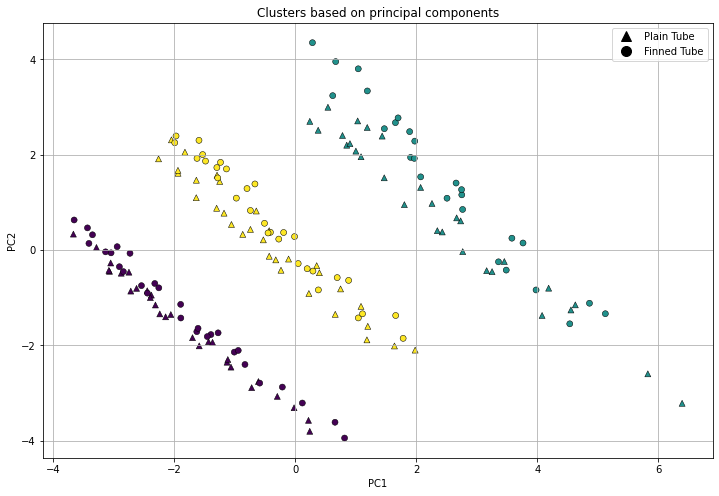

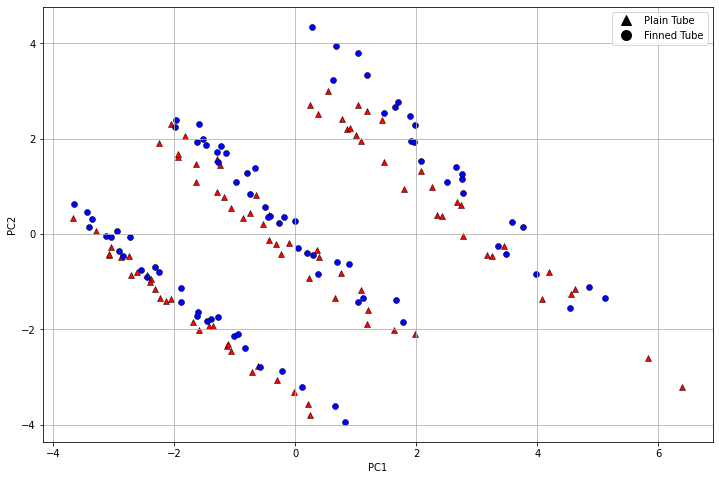

In [135]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
ax.scatter(Xdec[f1, 0], Xdec[f1, 1], 
    c=clusters[f1], 
    # color='red',
    cmap='viridis', linewidth=0.5, marker='^', edgecolors='black')
ax.scatter(Xdec[f2, 0], Xdec[f2, 1], 
           c=clusters[f2], 
        #    color='blue', 
           cmap='viridis', linewidth=0.5, marker='o', edgecolors='black')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.title("Clusters based on principal components")

# add legend
duz_boru = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                            markersize=10, label='Plain Tube')
mikrokanatli_boru = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                            markersize=10, label='Finned Tube')
ax.legend(handles=[duz_boru, mikrokanatli_boru]);
plt.grid()
plt.show()

# repeat plot for h colors

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
ax.scatter(Xdec[f1, 0], Xdec[f1, 1], 
    # c=clusters[f1], 
    color='red',
    cmap='viridis', linewidth=0.5, marker='^', edgecolors='black')
ax.scatter(Xdec[f2, 0], Xdec[f2, 1], 
        #    c=clusters[f2], 
           color='blue', 
           cmap='viridis', linewidth=0.5, marker='o', edgecolors='black')
# plt.title("Finned vs plain tube in pricincipal component space")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.grid()
# add legend
duz_boru = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                            markersize=10, label='Plain Tube')
mikrokanatli_boru = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                            markersize=10, label='Finned Tube')
ax.legend(handles=[duz_boru, mikrokanatli_boru])
plt.show()

# Heat Transfer coefficient

### Exploratory

In [136]:
data_h.groupby('dataset').agg(['mean']).T \
    .assign(Deviation=lambda x: x.diff(axis=1).iloc[:,1].abs() / x.iloc[:,1]) \
    .assign(Variable=H_NAMES.drop(11).tolist()) \
    .style.background_gradient(subset=['Deviation'], cmap='Reds') \
    .set_caption("Table: Input deviation statistics by tube type")

c:\Users\berk_\miniconda3\envs\cons1\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Eklenecek

In [137]:
d = data_h.copy()
d.columns = H_NAMES

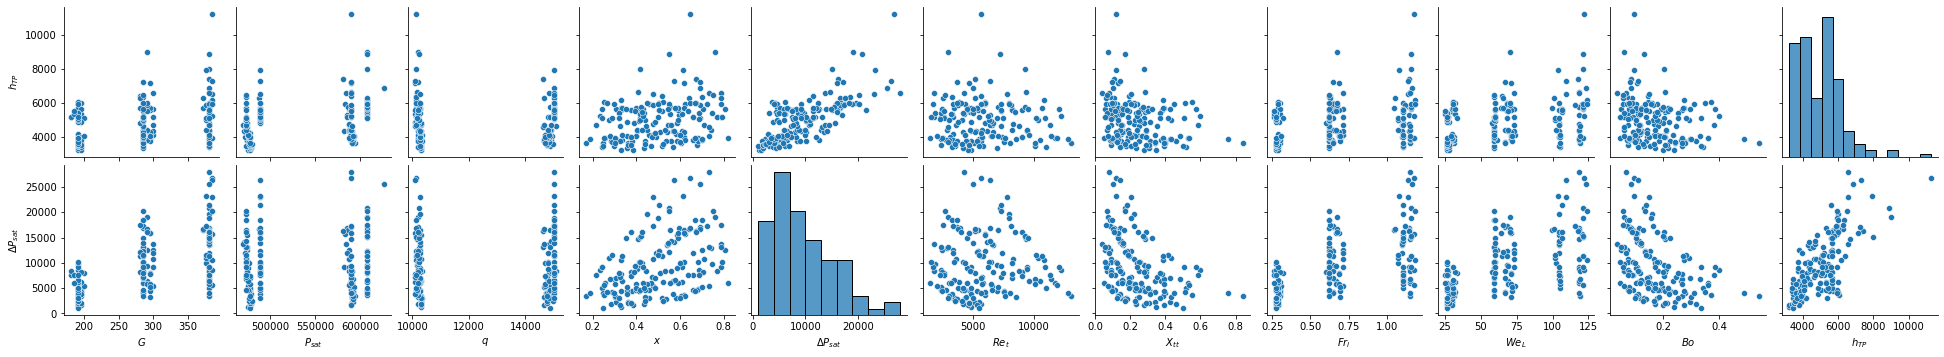

In [138]:
sns.pairplot(data=d.rename(NAME_KEYS, axis=1), y_vars=map(lambda x: NAME_KEYS[x], ['Heat transfer coefficient', 'Pressure drop']))
# plt.suptitle("Figure: Input and output interactions");

In [139]:
e = data_dp.copy()
e.columns = DP_NAMES

In [140]:
e

,Mass flux,Saturation pressure,Heat flux,Quality,Heat transfer coefficient,Reynolds number,Two-phase multiplier,Froude number,Weber number,Bond number,Pressure drop,Tube type
0,190.393921,589276.392344,10183.667411,0.286821,3744.893193,5624.264940,0.463739,0.287211,29.665103,0.317264,1908.497264,Plain tube dp
1,190.393921,591130.402063,10306.572617,0.306536,3906.912259,5475.898804,0.426594,0.287399,29.722737,0.294672,2238.123367,Plain tube dp
2,190.393921,591645.979654,10291.105025,0.360759,3658.382794,5049.426582,0.342545,0.287446,29.738299,0.242476,2184.774106,Plain tube dp
3,190.393921,590962.351114,10336.957572,0.456461,4117.791176,4291.402048,0.239386,0.287352,29.715816,0.176314,2998.877317,Plain tube dp
4,190.393921,591167.124112,10260.169839,0.583378,4183.575561,3289.825912,0.151131,0.287399,29.723428,0.117153,2961.531281,Plain tube dp
...,...,...,...,...,...,...,...,...,...,...,...,...
169,380.787842,472880.000000,15000.000000,0.245329,5109.722859,10906.194250,0.504140,1.102876,104.638108,0.333807,9227.000000,Microfin tube dp
170,380.787842,488370.000000,15000.000000,0.352100,5642.150585,9481.329941,0.322480,1.109093,106.470857,0.225151,14869.000000,Microfin tube dp
171,380.787842,488370.000000,15000.000000,0.424533,5459.440526,8421.352375,0.244931,1.109093,106.470857,0.176314,16015.000000,Microfin tube dp
172,380.787842,488370.000000,15000.000000,0.504202,5597.666983,7255.476964,0.183474,1.109093,106.470857,0.136383,21470.000000,Microfin tube dp


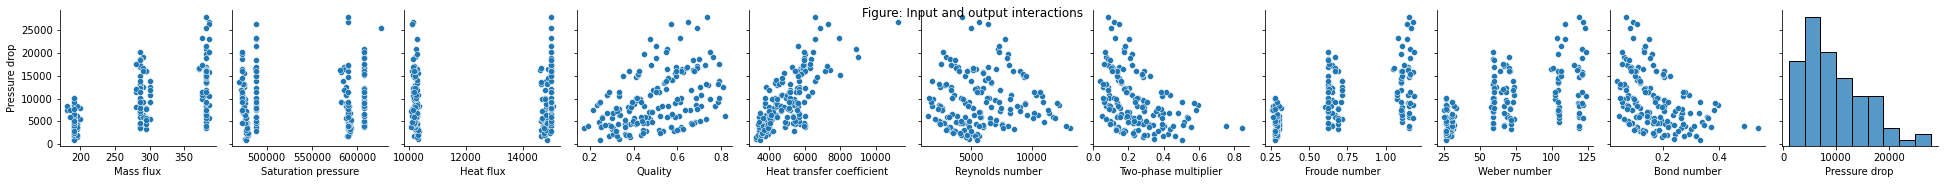

In [141]:
sns.pairplot(data=e, y_vars=['Pressure drop'])
plt.suptitle("Figure: Input and output interactions");

- Preesure drop / htp
- Heat transfet coef distribution
- Aynilarini pressure drop icin tekrar et (distribution)

Ayni figurde, a b c 

## Split

In [266]:
class Dataset:
    def __init__(self, data, X, y):
        self.data = data
        self.X = X
        self.y = y
        self.data_train: pd.DataFrame = None
        self.data_test: pd.DataFrame = None
        self.X_train: pd.DataFrame = None
        self.X_test: pd.DataFrame = None
        self.y_train: pd.DataFrame = None
        self.y_test: pd.DataFrame = None
        self.c_train: pd.Series = None
        self.c_test: pd.Series = None
        self.sample_category: pd.Series = None
        self.cats = None
        self.decpipeline: pipeline.Pipeline = None
        self.clusterer: pipeline.Pipeline = None
        self.clusters: pd.Series = None

    def setDec(self, decpipeline):
        self.decpipeline = decpipeline
        return self
    
    def setClusterer(self, clusterer):
        self.clusterer = clusterer
        return self
    
    def decompose(self):
        self.Xdec = self.decpipeline.fit_transform(self.X, self.y)
        return self

    def setCategories(self):
        self.clusters = pd.Series(self.clusterer.fit_predict(self.Xdec[:, :2]))

    def split(self, test_size=0.2, random_state=None):
        self.data_train, self.data_test, self.X_train, self.X_test, self.y_train, self.y_test, self.c_train, self.c_test = \
            model_selection.train_test_split(self.data, self.X, self.y, self.clusters, test_size=test_size, random_state=random_state, stratify=self.sample_category)
        return self
    
    def defineCats(self):
        self.sample_category = self.data['dataset'] + " c:" + pd.Series(self.clusters, index=self.data.index).astype(str)
        self.cats = self.data_train['dataset'] + "_" + pd.Series(self.c_train, index=self.data_train.index).map({0: 'A', 1: 'B', 2: 'C'}).astype('category').cat.codes.astype(str)
        return self

    def getPartitionedDataByDataset(self):
        return [self.data['dataset'] == tip  for tip in self.data['dataset'].unique()]
    
    def setRenameFunc(self, f):
        self.renameFunc = f
        return self
    
    def displayStatsByCat(self):
        return self.data_train.pipe(self.renameFunc).assign(Category=self.cats).groupby("Category").mean() \
            .style \
            .background_gradient(axis=0, cmap='Greens') \
            .set_caption("Input variable statistics by sample category")

In [267]:
htp = Dataset(data_h, Xh, yh)
htp.setRenameFunc(renameH)
htp.setDec(getDecPipeline())
htp.setClusterer(mixture.GaussianMixture(n_components=3, n_init=50, init_params='k-means++', max_iter=1000, tol=1e-6, ))
htp.decompose()
htp.setCategories()
htp.split(random_state=42, test_size=0.2)
htp.defineCats()

In [270]:
dp = Dataset(data_dp, Xdp, ydp)
dp.setRenameFunc(renameDP)
dp.setDec(getDecPipeline())
dp.setClusterer(mixture.GaussianMixture(n_components=3, n_init=50, init_params='k-means++', max_iter=1000, tol=1e-6, ))
dp.decompose()
dp.setCategories()
dp.split(random_state=42, test_size=0.2)
dp.defineCats()

In [142]:
sample_category = data_h['dataset'] + " c:" + pd.Series(clusters).astype(str)

In [143]:
data_train, data_test, X_train, X_test, y_train, y_test, c_train, c_test = model_selection.train_test_split(
    data_h, 
    Xh, 
    yh, 
    clusters, 
    test_size=0.3, 
    random_state=42, 
    stratify=sample_category
    )
# data_train_dp, data_test_dp, X_train_dp, X_test_dp, y_train_dp, y_test_dp, c_train_dp, c_test_dp = model_selection.train_test_split(data_dp, Xdp, ydp, clustersdp, test_size=0.2, random_state=42, stratify=clustersdp)

### Define categories based on clusters and pipe type

In [144]:
cats = ((data_train['dataset'] + "_" + pd.Series(c_train, index = data_train.index).map({0: 'A', 1: 'B', 2: 'C'})).astype('category').cat.codes)
# cats_dp = ((data_train_dp['dataset'] + "_" + pd.Series(c_train_dp, index = data_train_dp.index).map({0: 'A', 1: 'B', 2: 'C'})).astype('category').cat.codes)

In [145]:
data_train.pipe(renameH).assign(Category=cats).groupby("Category").mean() \
    .style \
    .background_gradient(axis=0, cmap='Greens') \
    .set_caption("Input variable statistics by sample category")

,Mass flux,Saturation pressure,Heat flux,Quality,Pressure drop,Reynolds number,Two-phase multiplier,Froude number,Weber number,Bond number,Heat transfer coefficient
Category,,,,,,,,,,,
0,190.393921,553191.000000,12336.142498,0.481821,5589.500000,3998.390457,0.252988,0.283684,28.588210,0.181192,5487.153987
1,380.787842,539760.555556,12318.045264,0.425252,16670.166667,8900.798707,0.309554,1.129399,112.750677,0.215895,6434.455493
2,286.270860,539451.904762,12924.940471,0.518304,12422.380952,5496.967950,0.208333,0.638356,63.710216,0.152202,5679.046310
3,191.583883,540143.644560,12098.984366,0.499268,3007.375710,3821.949287,0.226860,0.285933,28.542868,0.163996,3717.482447
4,380.549849,536835.695371,12763.618062,0.441479,10515.500000,8496.690598,0.283008,1.126809,112.227305,0.199934,4578.828087
5,289.701659,532606.721396,12729.165570,0.521075,7815.454545,5295.848858,0.200637,0.652614,64.864884,0.146484,4238.313992


Eklenecek

## ML pipelines

### Scoring definitions

In [146]:
scoring={
    "R2": metrics.make_scorer(metrics.r2_score),
    "RMSE": metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False, squared=False),
    "MAE": metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False),
    "MAPE": metrics.make_scorer(metrics.mean_absolute_percentage_error, greater_is_better=False),
    "Bias%": metrics.make_scorer(bias, greater_is_better=False),
    "WAPE%": metrics.make_scorer(lambda x, y: metrics.mean_absolute_percentage_error(x, y, sample_weight=y), greater_is_better=False),
    "Pearson-R": metrics.make_scorer(pearson)
}

#### Visual utils

In [147]:
def process_ann_results(cv, config_col_name='Selected ANN config', attributes=('hidden_layer_sizes', 'activation')):
    tablo_ann = (
        pd.DataFrame(cv)
        .sort_values(by='test_R2')
        .set_index('estimator')
        .rename_axis(index=config_col_name)
        # .rename(lambda x: ((n:=x.best_estimator_[-1].regressor_).hidden_layer_sizes ,n.activation))
        .rename(lambda x: tuple(getattr(x.best_estimator_[-1].regressor_, a) for a in attributes))
    )

    topten = tablo_ann[
        [col for col in tablo_ann.columns if 'test' in col]
        + [col for col in tablo_ann.columns if 'train' in col]
    ].sort_values('test_Pearson-R', ascending=False).reset_index().rename(renameScores , axis=1)

    ort_skor = tablo_ann.describe().pipe(lambda x: x[[c for c in x if "test" in c]]) \
        .T.drop("count", axis=1).round(4).rename(renameScores) \
        .style.set_caption("Scoring statistics for different models")

    return tablo_ann, topten, ort_skor

## Models

### ANN

In [148]:
olcekli_ann = compose.TransformedTargetRegressor(
    regressor=neural_network.MLPRegressor(hidden_layer_sizes=(40, 10), max_iter=4000, random_state=42),
    # regressor=ensemble.RandomForestRegressor(),
    # regressor=lgb.LGBMRegressor(),
    # regressor=tree.DecisionTreeRegressor(),
    transformer=preprocessing.StandardScaler()
    # transformer=preprocessing.FunctionTransformer(np.log, inverse_func=np.exp)
    # transformer=preprocessing.FunctionTransformer(np.sqrt, inverse_func=np.square)
)


ans = ensemble.AdaBoostRegressor(base_estimator=olcekli_ann, n_estimators=1)

polylog = pipeline.Pipeline([
    ("poly", preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
    ("log", preprocessing.FunctionTransformer(func=np.log1p, inverse_func=np.expm1))
])

union = pipeline.FeatureUnion([
    # ("sine", preprocessing.FunctionTransformer(np.sin)),
    # ("cosine", preprocessing.FunctionTransformer(np.cos)),
    # ("poly", preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#     ("poly", polylog),
    # ("scaler", preprocessing.FunctionTransformer(lambda x: x)),
    ("log", preprocessing.FunctionTransformer(func=np.log1p, inverse_func=np.expm1))
])

comp = compose.ColumnTransformer([
        # ('a', "passthrough", Xh.columns)
        # ("raw", "passthrough", Xh.columns.get_level_values(0) == 'Input Raw'),
    ], remainder='drop')


pipe = pipeline.Pipeline([
    # ("comp", comp),
    ("subselect", preprocessing.FunctionTransformer(lambda x: x['Input Raw'])),
    ('imputer', impute.SimpleImputer(strategy='mean')),
    # ('ink', union),
    # ("pca", kerdecpipeline),
    ("rescale", preprocessing.StandardScaler()),
    # ("selector", feature_selection.RFE(linear_model.LinearRegression(), n_features_to_select=None)),
    # ('select', feature_selection.(k=10)),
    ('mlp', olcekli_ann)
])



#### Grid search for MLP

In [149]:
gs = model_selection.GridSearchCV(
    pipe,
    param_grid={
        # 'mlp__base_estimator__regressor__hidden_layer_sizes': [
        'mlp__regressor__hidden_layer_sizes': [
            # (10, 10, 10, 10, 10), 
            # (10, 10, 10, 10, 10, 10), 
            # (10, 10, 10, 10, 10, 10, 10),
#             (20, 20), 
#             (40, 10),
#             (40, 40, 10),
#             (20, 20),
#             (10, 10),
            (128, 64, 32, 16, 8,)
            # (50, 50), 
            # (10, 5),
            # (5, 5)
            ],
        # 'mlp__base_estimator__regressor__activation': ['relu', 'tanh', 'logistic'],
        'mlp__regressor__activation': [
            'relu', 
#             'logistic'
        ],
        # 'mlp__base_estimator__regressor__max_iter': [1000, 2000, 3000, 4000, 5000],
        # 'mlp__regressor__max_iter': [1000, 2000, 3000, 4000, 5000],

        # 'mlp__regressor__tol': [1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
        'mlp__regressor__tol': [1e-5],
    },
    cv=model_selection.KFold(n_splits=3, shuffle=True, random_state=42),
    scoring=scoring,
    refit="R2",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

In [150]:
cv = model_selection.cross_validate(
    # estimator=local_pipe_gs,
    estimator=gs,
    X=X_train, 
    y=y_train, 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=20, shuffle=True, random_state=42),
#     cv=model_selection.LeaveOneOut(),
    scoring=scoring,
    return_train_score=True, 
    return_estimator=True, 
    n_jobs=-1, 
    verbose=2,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
c:\Users\berk_\miniconda3\envs\cons1\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 18 members, which is less than n_splits=20.
  warnings.warn(


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.3s finished


In [151]:
tablo_ann, ort_skor, _ = process_ann_results(cv)
display(tablo_ann)
display(ort_skor)
display(_)

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE,test_MAE,train_MAE,test_MAPE,train_MAPE,test_Bias%,train_Bias%,test_WAPE%,train_WAPE%,test_Pearson-R,train_Pearson-R
Selected ANN config,,,,,,,,,,,,,,,,
"((128, 64, 32, 16, 8), relu)",4.175472,0.018012,-2.234616,0.998519,-1580.139245,-48.117675,-1031.433401,-31.701518,-0.179867,-0.006510,-0.197969,0.001395,-0.234882,-0.006362,0.789083,0.998550
"((128, 64, 32, 16, 8), relu)",3.389084,0.010000,0.367949,0.998463,-387.572752,-48.996449,-311.849439,-32.233634,-0.080445,-0.006534,0.007292,-0.003390,-0.077982,-0.006444,0.450666,0.998650
"((128, 64, 32, 16, 8), relu)",4.716896,0.025525,0.457976,0.999056,-840.525118,-38.015485,-665.551477,-23.426304,-0.113752,-0.004939,0.084000,0.001962,-0.117031,-0.004710,0.622783,0.999120
"((128, 64, 32, 16, 8), relu)",6.650477,0.161538,0.509716,0.997604,-904.971079,-60.211574,-586.362882,-38.351714,-0.095924,-0.007879,0.073151,-0.000084,-0.099989,-0.007711,0.704150,0.997606
"((128, 64, 32, 16, 8), relu)",5.440127,0.145531,0.529698,0.998398,-498.713263,-50.270254,-393.683832,-38.651941,-0.075527,-0.008056,-0.031818,-0.005480,-0.080400,-0.007777,0.635399,0.998873
"((128, 64, 32, 16, 8), relu)",4.507829,0.039525,0.596121,0.998166,-755.736890,-52.992537,-431.646549,-33.523757,-0.083837,-0.007136,-0.070306,-0.000129,-0.100465,-0.006723,0.820512,0.998168
"((128, 64, 32, 16, 8), relu)",7.310670,0.064523,0.667629,0.998358,-735.990248,-49.947820,-511.112439,-27.627540,-0.090587,-0.005680,-0.069995,0.000093,-0.107543,-0.005553,0.886606,0.998364
"((128, 64, 32, 16, 8), relu)",5.093012,0.040998,0.784957,0.998840,-395.739769,-42.507419,-299.285398,-23.563021,-0.053214,-0.005033,0.029297,-0.000148,-0.052722,-0.004758,0.823819,0.998842
"((128, 64, 32, 16, 8), relu)",4.609358,0.023002,0.810900,0.999165,-305.271103,-36.241061,-266.247978,-21.180887,-0.058645,-0.004394,0.007710,0.000604,-0.057550,-0.004239,0.902257,0.999172


,Selected ANN config,Test R2,Test RMSE,Test MAE,Test MAPE,Test Bias%,Test WAPE%,Test Pearson-R,Train R2,Train RMSE,Train MAE,Train MAPE,Train Bias%,Train WAPE%,Train Pearson-R
0,"((128, 64, 32, 16, 8), relu)",0.964253,-158.667370,-142.581454,-0.029211,-0.002582,-0.030377,0.982107,0.998965,-40.243410,-27.177654,-0.005732,0.002038,-0.005428,0.999033
1,"((128, 64, 32, 16, 8), relu)",0.946488,-255.432209,-221.450858,-0.046044,0.017993,-0.045410,0.979504,0.999082,-37.650560,-25.662371,-0.005373,0.002343,-0.005136,0.999171
2,"((128, 64, 32, 16, 8), relu)",0.885273,-874.545144,-537.699827,-0.074367,0.032673,-0.087886,0.974234,0.998850,-37.609655,-27.120665,-0.005667,-0.003061,-0.005484,0.999041
3,"((128, 64, 32, 16, 8), relu)",0.973260,-263.969159,-225.662754,-0.040324,-0.006347,-0.043711,0.973864,0.998356,-49.099048,-33.027224,-0.006805,-0.003253,-0.006658,0.998536
4,"((128, 64, 32, 16, 8), relu)",0.901497,-267.347115,-229.043580,-0.052391,0.032727,-0.050287,0.958324,0.998571,-47.059896,-32.308659,-0.006578,0.002868,-0.006437,0.998711
5,"((128, 64, 32, 16, 8), relu)",0.949416,-388.073220,-242.976191,-0.050633,0.024114,-0.041716,0.955933,0.998964,-38.654737,-23.848418,-0.005008,0.001077,-0.004801,0.998986
6,"((128, 64, 32, 16, 8), relu)",0.903519,-308.239168,-215.718986,-0.044805,0.029434,-0.040466,0.943418,0.997759,-59.008694,-42.322515,-0.008740,0.004012,-0.008475,0.998021
7,"((128, 64, 32, 16, 8), relu)",0.898440,-289.058948,-224.929431,-0.051495,0.018941,-0.048087,0.915124,0.998481,-48.536960,-26.124513,-0.005266,0.000116,-0.005228,0.998488
8,"((128, 64, 32, 16, 8), relu)",0.810900,-305.271103,-266.247978,-0.058645,0.007710,-0.057550,0.902257,0.999165,-36.241061,-21.180887,-0.004394,0.000604,-0.004239,0.999172
9,"((128, 64, 32, 16, 8), relu)",0.881833,-330.843145,-288.055854,-0.060698,0.003760,-0.060110,0.894303,0.998519,-48.010404,-26.880023,-0.005659,0.000727,-0.005399,0.998531


,mean,std,min,25%,50%,75%,max
Test R2,0.623800,0.698000,-2.234600,0.579500,0.840600,0.902000,0.973300
Test RMSE,-513.009300,341.877700,-1580.139200,-740.926900,-387.823000,-298.635300,-158.667400
Test MAE,-371.269100,209.727500,-1031.433400,-451.513000,-293.670600,-228.198400,-142.581500
Test MAPE,-0.070100,0.033200,-0.179900,-0.081300,-0.059700,-0.051300,-0.029200
Test Bias%,-0.000500,0.059700,-0.198000,-0.003500,0.007500,0.029300,0.084000
Test WAPE%,-0.074900,0.045200,-0.234900,-0.090900,-0.060300,-0.047400,-0.030400
Test Pearson-R,0.845200,0.143300,0.450700,0.812700,0.890500,0.956500,0.982100


Eklenecek

In [152]:
gs.fit(X_train, y_train, groups=cats.values);

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [153]:
y_pred = gs.predict(X_test)

In [154]:
y_pred_train = gs.predict(X_train)

In [155]:
scores = {}
for k, v in scoring.items():
    scores[k] = v._score_func(y_test, y_pred, **v._kwargs)

In [156]:
bias(y_test, y_pred)

0
Output 1    0.01618
dtype: float64

In [157]:
pd.Series(scores).to_frame()

,0
R2,0.808612
RMSE,512.773568
MAE,354.782387
MAPE,0.070678
Bias%,0 Output 1 0.01618 dtype: float64
WAPE%,0.074179
Pearson-R,0.820956


Eklenecek

### Local Regression definition

In [158]:
ctlocal = compose.TransformedTargetRegressor(regressor=LocallyWeightedRegressor(n_neighbors=15, gamma=.1), 
                                            # func=np.log1p, 
                                            func=lambda x: x, 
                                            #  inverse_func=np.expm1
                                             inverse_func=lambda x: x
                                            )


local_pipe = pipeline.Pipeline([
    ("subselect", preprocessing.FunctionTransformer(lambda x: x['Input Raw'])),
    # ("comp", comp),
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('ink', union),
    ("rescale", preprocessing.StandardScaler()),
    ('mlp', ctlocal)
])

In [159]:
local_pipe_gs = model_selection.GridSearchCV(
    estimator=local_pipe,
    param_grid={
        'mlp__regressor__n_neighbors': [5, 10, 15, 20],
#         'mlp__regressor__n_neighbors': [1],
        'mlp__regressor__gamma': [.7, 1, 2, 3]
    },
    scoring=scoring,
    refit='R2',
    cv=3,
)
    

### Cross validation

In [160]:
cv_lwr = model_selection.cross_validate(
    estimator=local_pipe_gs,
    # estimator=gs,
    X=X_train, 
    y=y_train, 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     cv=model_selection.LeaveOneOut(),
    scoring=scoring,
    return_train_score=True, 
    return_estimator=True, 
    n_jobs=-1, 
    verbose=2,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


In [161]:
tablo_lwr, ort_lwr, _ = process_ann_results(cv_lwr, config_col_name='Selected LWR config', attributes=('n_neighbors', 'gamma'))

display(tablo_lwr)
display(ort_lwr)

display(_)

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE,test_MAE,train_MAE,test_MAPE,train_MAPE,test_Bias%,train_Bias%,test_WAPE%,train_WAPE%,test_Pearson-R,train_Pearson-R
Selected LWR config,,,,,,,,,,,,,,,,
"(15, 0.7)",3.063063,0.041534,0.374439,0.945602,-745.127330,-299.894141,-440.994818,-206.106082,-0.090732,-0.040951,-0.005340,-0.016210,-0.091279,-0.041724,0.802875,0.949926
"(15, 1)",3.077074,0.048522,0.639174,0.969420,-695.495705,-219.080399,-455.446855,-158.281719,-0.095947,-0.032277,-0.054001,-0.011732,-0.100538,-0.032262,0.755833,0.971762
"(20, 0.7)",3.068070,0.036534,0.639350,0.944314,-652.883441,-299.445211,-447.734408,-203.638237,-0.082546,-0.041301,0.011644,-0.016790,-0.085366,-0.041864,0.644561,0.948794
"(10, 2)",3.114588,0.047523,0.721232,0.996244,-849.334706,-68.411161,-535.144572,-42.097725,-0.097307,-0.008484,-0.003521,-0.002925,-0.104511,-0.008514,0.754556,0.996582
"(15, 0.7)",3.086576,0.047536,0.766149,0.936076,-583.450533,-313.401913,-456.761662,-203.554747,-0.091572,-0.040697,-0.061009,-0.012911,-0.093773,-0.042291,0.851388,0.939730


,Selected LWR config,Test R2,Test RMSE,Test MAE,Test MAPE,Test Bias%,Test WAPE%,Test Pearson-R,Train R2,Train RMSE,Train MAE,Train MAPE,Train Bias%,Train WAPE%,Train Pearson-R
0,"(15, 0.7)",0.766149,-583.450533,-456.761662,-0.091572,-0.061009,-0.093773,0.851388,0.936076,-313.401913,-203.554747,-0.040697,-0.012911,-0.042291,0.939730
1,"(15, 0.7)",0.374439,-745.127330,-440.994818,-0.090732,-0.005340,-0.091279,0.802875,0.945602,-299.894141,-206.106082,-0.040951,-0.016210,-0.041724,0.949926
2,"(15, 1)",0.639174,-695.495705,-455.446855,-0.095947,-0.054001,-0.100538,0.755833,0.969420,-219.080399,-158.281719,-0.032277,-0.011732,-0.032262,0.971762
3,"(10, 2)",0.721232,-849.334706,-535.144572,-0.097307,-0.003521,-0.104511,0.754556,0.996244,-68.411161,-42.097725,-0.008484,-0.002925,-0.008514,0.996582
4,"(20, 0.7)",0.639350,-652.883441,-447.734408,-0.082546,0.011644,-0.085366,0.644561,0.944314,-299.445211,-203.638237,-0.041301,-0.016790,-0.041864,0.948794


,mean,std,min,25%,50%,75%,max
Test R2,0.628100,0.151900,0.374400,0.639200,0.639400,0.721200,0.766100
Test RMSE,-705.258300,100.028900,-849.334700,-745.127300,-695.495700,-652.883400,-583.450500
Test MAE,-467.216500,38.500600,-535.144600,-456.761700,-455.446900,-447.734400,-440.994800
Test MAPE,-0.091600,0.005800,-0.097300,-0.095900,-0.091600,-0.090700,-0.082500
Test Bias%,-0.022400,0.032800,-0.061000,-0.054000,-0.005300,-0.003500,0.011600
Test WAPE%,-0.095100,0.007600,-0.104500,-0.100500,-0.093800,-0.091300,-0.085400
Test Pearson-R,0.761800,0.076700,0.644600,0.754600,0.755800,0.802900,0.851400


In [162]:
local_pipe_gs.fit(X_train, y_train);

In [163]:
y_pred = local_pipe_gs.predict(X_test)

In [164]:
scores = {}
for k, v in scoring.items():
    scores[k] = v._score_func(y_test.values[:,-1], y_pred[:, -1], **v._kwargs)

LWR test scores

In [165]:
pd.Series(scores).to_frame()

,0
R2,0.817250
RMSE,501.069149
MAE,362.621327
MAPE,0.073873
Bias%,0.045037
WAPE%,0.076910
Pearson-R,0.861246


Eklenecek - ANN tablolari ile birlestirerek sunulacak

## LGBM

#### LGBM definition

In [166]:
# Fit an lgbm model

lgbm_pipe = pipeline.Pipeline([
    # ("subselect", preprocessing.FunctionTransformer(lambda x: x['Input Raw'])),
    # ("comp", comp),
    ('imputer', impute.SimpleImputer(strategy='mean')),
    ('ink', union),
    ("rescale", preprocessing.StandardScaler()),
    ('mlp', compose.TransformedTargetRegressor(regressor=lgb.LGBMRegressor(), func=lambda x : x, inverse_func=lambda x: x))
])

lgbm_pipe_gs = model_selection.GridSearchCV(
    estimator=lgbm_pipe,
    param_grid={
        # 'mlp__n_estimators': [10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
        # 'mlp__regressor__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, None],
        # 'mlp__regressor__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
        # 'mlp__num_leaves': [2, 4, 8, 16, 32, 64, 128, 256, 512],
        'mlp__regressor__reg_alpha': [0, 0.1, 0.5, 1, 2, 3, 4, 5, 10],
        # 'mlp__reg_lambda': [0, 0.1, 0.5, 1, 2, 3, 4, 5, 10],
        # 'mlp__min_child_samples': [5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
        # 'mlp__min_child_weight': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        # 'mlp__min_split_gain': [0, 0.1, 0.5, 1, 2, 3, 4, 5, 10],
        # 'mlp__colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7],
        # 'mlp__subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7],
    },
    scoring=scoring,
    refit='R2',
    cv=3,
    n_jobs=-1,
    verbose=2,
)

cv_lgbm = model_selection.cross_validate(
    estimator=lgbm_pipe_gs,
    # estimator=gs,
    X=X_train, 
    y=y_train.values[:, -1], 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[CV] END .................................................... total time=   0.2s
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................................................... total time=   0.2s
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................................................... total time=   0.2s
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished


#### LGBM scoring

In [167]:

tablo_lgbm, ort_lgbm, _ = process_ann_results(cv_lgbm, config_col_name='Selected LGBM config', attributes=('n_estimators', 'learning_rate', 'max_depth', 'num_leaves', 'reg_alpha', 'reg_lambda', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'colsample_bytree', 'subsample'))

display(tablo_lgbm)
display(ort_lgbm)
display(_)

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE,test_MAE,train_MAE,test_MAPE,train_MAPE,test_Bias%,train_Bias%,test_WAPE%,train_WAPE%,test_Pearson-R,train_Pearson-R
Selected LGBM config,,,,,,,,,,,,,,,,
"(100, 0.1, -1, 31, 0.5, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.313561,0.004998,0.478291,0.823915,-785.247883,-532.482832,-611.120697,-323.049835,-0.125424,-0.062004,-0.035495,-2.478615e-07,-0.131384,-0.064316,0.505800,0.836114
"(100, 0.1, -1, 31, 0, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.281566,0.007002,0.502337,0.859254,-1134.815873,-418.803099,-669.345949,-310.441668,-0.113989,-0.061582,0.074055,9.134265e-10,-0.123243,-0.062650,0.604029,0.864739
"(100, 0.1, -1, 31, 3, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.308563,0.004999,0.559283,0.801526,-768.644486,-558.126866,-549.119271,-368.211546,-0.102241,-0.072449,0.005223,1.600041e-06,-0.104155,-0.073870,0.559841,0.815928
"(100, 0.1, -1, 31, 0, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.301090,0.005000,0.669599,0.792020,-541.521935,-586.389885,-404.473099,-371.754731,-0.096565,-0.069033,-0.036577,-8.310491e-10,-0.094667,-0.073432,0.707867,0.806171
"(100, 0.1, -1, 31, 10, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.344581,0.005507,0.759329,0.767802,-591.897279,-597.308512,-477.577300,-390.418429,-0.097858,-0.075318,-0.029839,3.032023e-06,-0.098078,-0.078312,0.775946,0.784724


,Selected LGBM config,Test R2,Test RMSE,Test MAE,Test MAPE,Test Bias%,Test WAPE%,Test Pearson-R,Train R2,Train RMSE,Train MAE,Train MAPE,Train Bias%,Train WAPE%,Train Pearson-R
0,"(100, 0.1, -1, 31, 10, 0.0, 20, 0.001, 0.0, 1....",0.759329,-591.897279,-477.577300,-0.097858,-0.029839,-0.098078,0.775946,0.767802,-597.308512,-390.418429,-0.075318,3.032023e-06,-0.078312,0.784724
1,"(100, 0.1, -1, 31, 0, 0.0, 20, 0.001, 0.0, 1.0...",0.669599,-541.521935,-404.473099,-0.096565,-0.036577,-0.094667,0.707867,0.792020,-586.389885,-371.754731,-0.069033,-8.310491e-10,-0.073432,0.806171
2,"(100, 0.1, -1, 31, 0, 0.0, 20, 0.001, 0.0, 1.0...",0.502337,-1134.815873,-669.345949,-0.113989,0.074055,-0.123243,0.604029,0.859254,-418.803099,-310.441668,-0.061582,9.134265e-10,-0.062650,0.864739
3,"(100, 0.1, -1, 31, 3, 0.0, 20, 0.001, 0.0, 1.0...",0.559283,-768.644486,-549.119271,-0.102241,0.005223,-0.104155,0.559841,0.801526,-558.126866,-368.211546,-0.072449,1.600041e-06,-0.073870,0.815928
4,"(100, 0.1, -1, 31, 0.5, 0.0, 20, 0.001, 0.0, 1...",0.478291,-785.247883,-611.120697,-0.125424,-0.035495,-0.131384,0.505800,0.823915,-532.482832,-323.049835,-0.062004,-2.478615e-07,-0.064316,0.836114


,mean,std,min,25%,50%,75%,max
Test R2,0.593800,0.118400,0.478300,0.502300,0.559300,0.669600,0.759300
Test RMSE,-764.425500,232.965900,-1134.815900,-785.247900,-768.644500,-591.897300,-541.521900
Test MAE,-542.327300,105.010400,-669.345900,-611.120700,-549.119300,-477.577300,-404.473100
Test MAPE,-0.107200,0.012300,-0.125400,-0.114000,-0.102200,-0.097900,-0.096600
Test Bias%,-0.004500,0.047200,-0.036600,-0.035500,-0.029800,0.005200,0.074100
Test WAPE%,-0.110300,0.016200,-0.131400,-0.123200,-0.104200,-0.098100,-0.094700
Test Pearson-R,0.630700,0.110000,0.505800,0.559800,0.604000,0.707900,0.775900


In [168]:
lgbm_pipe_gs.fit(X_train, y_train.values[:, -1]);

y_pred = lgbm_pipe_gs.predict(X_test)

scores = {}

for k, v in scoring.items():
    scores[k] = v._score_func(y_test.values[:, -1], y_pred, **v._kwargs)

pd.Series(scores).to_frame()

Fitting 3 folds for each of 9 candidates, totalling 27 fits


,0
R2,0.771577
RMSE,560.193494
MAE,424.403253
MAPE,0.084340
Bias%,0.017456
WAPE%,0.085496
Pearson-R,0.778467


## HTP EVAL

In [169]:
model1 = gs
model2 = local_pipe_gs
model3 = lgbm_pipe_gs

In [170]:
# f = data_h['dataset'] == 'Plain tube h'
f = data_h['dataset'].notnull()
model1.fit(X_train, y_train, 
#            groups=cats.values
          )
model2.fit(X_train, y_train, 
#            groups=cats.values
          )
model3.fit(X_train, y_train,
#            groups=cats.values
          ) 
pass

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [171]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

In [172]:
plain_indices = (data_h['dataset'] == 'Plain tube h').loc[y_test.index].index
finned_indices = (data_h['dataset'] == 'Microfin tube h').loc[y_test.index].index

In [173]:
scores1 = {}
scores2 = {}
scores3 = {}
for k, v in scoring.items():
    scores1[k] = v._score_func(y_test, y_pred1, **v._kwargs)
    scores2[k] = v._score_func(y_test, y_pred2, **v._kwargs)
    scores3[k] = v._score_func(y_test, y_pred3, **v._kwargs)

In [174]:
pd.DataFrame([scores1, scores2, scores3], index=['ANN', 'LWR', 'LGBM']).assign(**{"Bias%": lambda x: x["Bias%"].apply(lambda x: x.iloc[0])})

,R2,RMSE,MAE,MAPE,Bias%,WAPE%,Pearson-R
ANN,0.808612,512.773568,354.782387,0.070678,0.016180,0.074179,0.820956
LWR,0.817250,501.069149,362.621327,0.073873,0.045037,0.076910,0.861246
LGBM,0.771577,560.193494,424.403253,0.084340,0.017456,0.085496,0.778467


In [175]:
x1 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred1.ravel()]).T
x2 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred2.ravel()]).T
x3 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred3.ravel()]).T

In [176]:
def plot_predictions(data_h, data_test, y_test, ypreds, model_names):
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    markers = ['o', 's', 'D', 'v', '^', 'p', '*', 'h']
    
    dataset_types = data_h['dataset'].unique()
    num_datasets = len(dataset_types)
    
    fig, axs = plt.subplots(nrows=num_datasets, ncols=len(ypreds), figsize=(20, 8*num_datasets), sharey=True)
    
    for row, dataset_type in enumerate(dataset_types):
        f = data_test['dataset'] == dataset_type
        
        for col, ypred in enumerate(ypreds):
            axs[row, col].scatter(y_test[f], ypred[f], color=colors[col], marker=markers[col], label='Prediction', alpha=0.5)
        
            xlims = tuple(axs[row, col].get_xlim())
            ylims = tuple(axs[row, col].get_ylim())

            ori = y_test[f].iloc[0,0]

            axs[row, col].grid()
            axs[row, col].axline((ori, ori), slope=1, label='x=y')
            axs[row, col].axline((ori, ori*1.1), slope=1.1, color='black', linestyle=':', label="+-10%")
            axs[row, col].axline((ori, ori*1.3), slope=1.3, color='gray', linestyle='--', label="+-30%")
            axs[row, col].axline((ori, ori*0.9), slope=0.9, color='black', linestyle=':')
            axs[row, col].axline((ori, ori*0.7), slope=0.7, color='gray', linestyle='--')
            if col == 0:
                axs[row, col].legend()
                axs[row, col].set_ylabel("$\hat{h_{TP}}$")
            axs[row, col].set_xlabel("$h_{TP}$")
            axs[row, col].set_xlim(xlims)
            axs[row, col].set_ylim(ylims)
            axs[row, col].axis("equal")
            axs[row, col].set_title(f"{model_names[col]} - {dataset_type}")  # Set model name as title
    
        # fig.suptitle(f"Dataset Type: {dataset_type}", fontsize=16, y=0.92)
    
    plt.tight_layout()


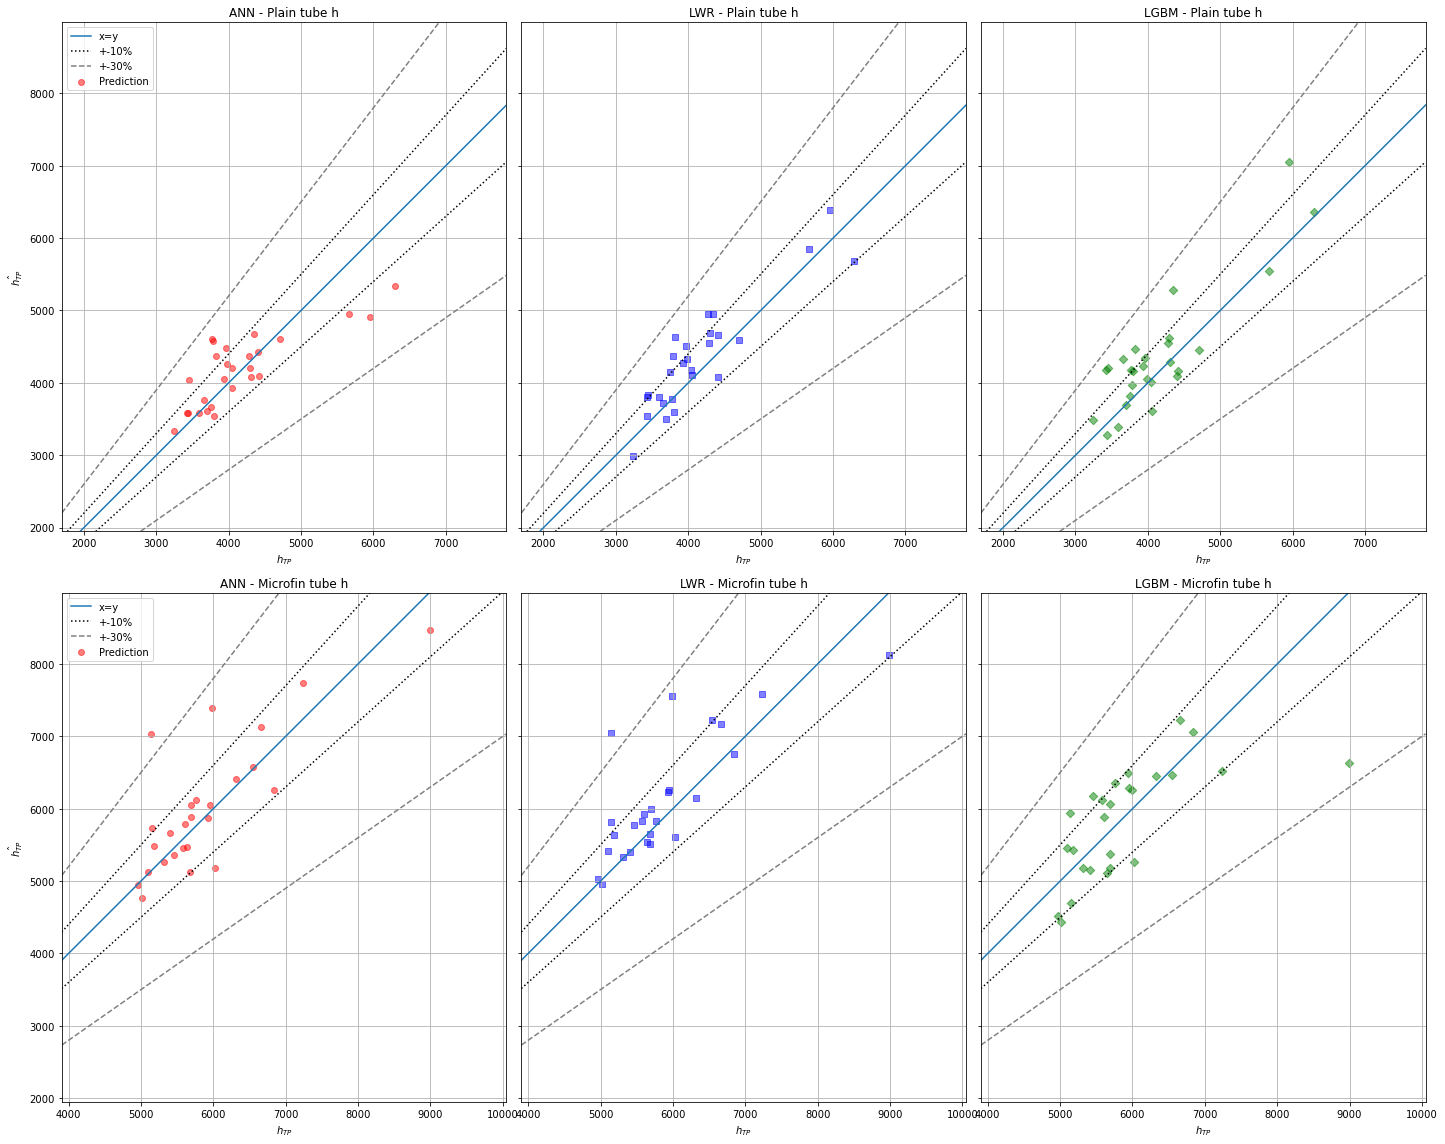

In [177]:

plot_predictions(data_h, data_test, y_test, [y_pred1, y_pred2, y_pred3], ['ANN', 'LWR', 'LGBM'])


Eklenecek - a,b   (aynilarini dp icin de a,b seklinde ekleriz)

# Pressure Drop

In [178]:
sample_category_dp = data_dp['dataset'] + " c:" + pd.Series(clustersdp).astype(str)

In [179]:
data_train, data_test, X_train, X_test, y_train, y_test, c_train, c_test = model_selection.train_test_split(
    data_dp, 
    Xdp, 
    ydp, 
    clustersdp, 
    test_size=0.3, 
    random_state=42, 
    stratify=sample_category_dp
    )
# data_train_dp, data_test_dp, X_train_dp, X_test_dp, y_train_dp, y_test_dp, c_train_dp, c_test_dp = model_selection.train_test_split(data_dp, Xdp, ydp, clustersdp, test_size=0.2, random_state=42, stratify=clustersdp)

In [180]:
cats = ((data_train['dataset'] + "_" + pd.Series(c_train, index = data_train.index).map({0: 'A', 1: 'B', 2: 'C'})).astype('category').cat.codes)

## ANN

In [181]:
cv = model_selection.cross_validate(
    # estimator=local_pipe_gs,
    estimator=gs,
    X=X_train, 
    y=y_train, 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     cv=model_selection.LeaveOneOut(),
    scoring=scoring,
    return_train_score=True, 
    return_estimator=True, 
    n_jobs=-1, 
    verbose=2,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


In [182]:
tablo_ann_dp, topten_dp, ort_skor_dp = process_ann_results(cv)
display(tablo_ann_dp)
display(ort_skor_dp)
display(topten_dp)

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE,test_MAE,train_MAE,test_MAPE,train_MAPE,test_Bias%,train_Bias%,test_WAPE%,train_WAPE%,test_Pearson-R,train_Pearson-R
Selected ANN config,,,,,,,,,,,,,,,,
"((128, 64, 32, 16, 8), relu)",2.545395,0.019996,0.694263,0.997634,-3066.414461,-283.480949,-1661.507123,-161.648236,-0.155486,-0.018781,-0.130052,-0.000011,-0.206172,-0.017613,0.914067,0.997635
"((128, 64, 32, 16, 8), relu)",2.651918,0.021004,0.846352,0.998643,-2777.986094,-197.408779,-1360.756529,-141.244460,-0.123529,-0.021057,0.061487,-0.000077,-0.120572,-0.015604,0.883478,0.998646
"((128, 64, 32, 16, 8), relu)",2.543395,0.013006,0.909526,0.999340,-1658.207982,-149.856009,-1123.453215,-82.319608,-0.120289,-0.010717,-0.006186,-0.000009,-0.118669,-0.008949,0.910145,0.999341
"((128, 64, 32, 16, 8), relu)",2.859969,0.012001,0.927331,0.999544,-1396.587016,-126.175083,-940.952876,-72.652739,-0.099015,-0.009978,0.056730,-0.000264,-0.102109,-0.007751,0.949101,0.999544
"((128, 64, 32, 16, 8), relu)",2.853969,0.012002,0.941070,0.997693,-1240.171936,-283.680678,-921.858741,-144.235170,-0.174365,-0.018651,-0.024623,-0.000374,-0.123221,-0.015284,0.945086,0.997694


,mean,std,min,25%,50%,75%,max
Test R2,0.863700,0.101400,0.694300,0.846400,0.909500,0.927300,0.941100
Test RMSE,-2027.873500,836.194500,-3066.414500,-2777.986100,-1658.208000,-1396.587000,-1240.171900
Test MAE,-1201.705700,311.907200,-1661.507100,-1360.756500,-1123.453200,-940.952900,-921.858700
Test MAPE,-0.134500,0.030000,-0.174400,-0.155500,-0.123500,-0.120300,-0.099000
Test Bias%,-0.008500,0.077800,-0.130100,-0.024600,-0.006200,0.056700,0.061500
Test WAPE%,-0.134100,0.041100,-0.206200,-0.123200,-0.120600,-0.118700,-0.102100
Test Pearson-R,0.920400,0.027100,0.883500,0.910100,0.914100,0.945100,0.949100


,Selected ANN config,Test R2,Test RMSE,Test MAE,Test MAPE,Test Bias%,Test WAPE%,Test Pearson-R,Train R2,Train RMSE,Train MAE,Train MAPE,Train Bias%,Train WAPE%,Train Pearson-R
0,"((128, 64, 32, 16, 8), relu)",0.927331,-1396.587016,-940.952876,-0.099015,0.056730,-0.102109,0.949101,0.999544,-126.175083,-72.652739,-0.009978,-0.000264,-0.007751,0.999544
1,"((128, 64, 32, 16, 8), relu)",0.941070,-1240.171936,-921.858741,-0.174365,-0.024623,-0.123221,0.945086,0.997693,-283.680678,-144.235170,-0.018651,-0.000374,-0.015284,0.997694
2,"((128, 64, 32, 16, 8), relu)",0.694263,-3066.414461,-1661.507123,-0.155486,-0.130052,-0.206172,0.914067,0.997634,-283.480949,-161.648236,-0.018781,-0.000011,-0.017613,0.997635
3,"((128, 64, 32, 16, 8), relu)",0.909526,-1658.207982,-1123.453215,-0.120289,-0.006186,-0.118669,0.910145,0.999340,-149.856009,-82.319608,-0.010717,-0.000009,-0.008949,0.999341
4,"((128, 64, 32, 16, 8), relu)",0.846352,-2777.986094,-1360.756529,-0.123529,0.061487,-0.120572,0.883478,0.998643,-197.408779,-141.244460,-0.021057,-0.000077,-0.015604,0.998646


In [183]:
gs.fit(X_train, y_train, groups=cats.values);

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [184]:
y_pred = gs.predict(X_test)

In [185]:
y_pred_train = gs.predict(X_train)

In [186]:
scores = {}
for k, v in scoring.items():
    scores[k] = v._score_func(y_test, y_pred, **v._kwargs)

In [187]:
pd.Series(scores).to_frame()

,0
R2,0.919271
RMSE,1684.920325
MAE,967.897236
MAPE,0.101603
Bias%,0 Output 1 0.022223 dtype: float64
WAPE%,0.107907
Pearson-R,0.935171


## Local Regression definition

In [188]:
cv_lwr = model_selection.cross_validate(
    estimator=local_pipe_gs,
    # estimator=gs,
    X=X_train, 
    y=y_train, 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     cv=model_selection.LeaveOneOut(),
    scoring=scoring,
    return_train_score=True, 
    return_estimator=True, 
    n_jobs=-1, 
    verbose=2,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


In [189]:
tablo_lwr_dp, ort_lwr_dp, _ = process_ann_results(cv_lwr, config_col_name='Selected LWR config', attributes=('n_neighbors', 'gamma'))

display(tablo_lwr_dp)
display(ort_lwr_dp)
display(_)

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE,test_MAE,train_MAE,test_MAPE,train_MAPE,test_Bias%,train_Bias%,test_WAPE%,train_WAPE%,test_Pearson-R,train_Pearson-R
Selected LWR config,,,,,,,,,,,,,,,,
"(20, 1)",3.357518,0.044531,0.721045,0.988417,-2929.030983,-627.266984,-1508.904497,-425.306160,-0.137841,-0.056098,-0.137625,-0.012156,-0.187970,-0.047614,0.917559,0.988965
"(20, 0.7)",3.287530,0.035013,0.870848,0.973001,-2546.927149,-880.650308,-1492.210941,-574.370234,-0.139337,-0.067458,0.068474,-0.007623,-0.144169,-0.063973,0.926528,0.973871
"(20, 1)",3.189997,0.044543,0.902347,0.981555,-1722.743509,-792.341570,-1030.890408,-476.239471,-0.102537,-0.059724,-0.000004,-0.012449,-0.105631,-0.054141,0.903830,0.982310
"(20, 0.7)",3.200000,0.048517,0.922155,0.968498,-1425.375285,-1048.344574,-1063.706083,-637.461973,-0.169033,-0.071779,-0.027556,-0.015867,-0.135024,-0.069746,0.924345,0.969580
"(20, 1)",3.160989,0.051009,0.957432,0.979191,-1068.889064,-852.221215,-745.905475,-518.079376,-0.089043,-0.059927,0.017277,-0.012019,-0.081416,-0.057204,0.961876,0.980363


,Selected LWR config,Test R2,Test RMSE,Test MAE,Test MAPE,Test Bias%,Test WAPE%,Test Pearson-R,Train R2,Train RMSE,Train MAE,Train MAPE,Train Bias%,Train WAPE%,Train Pearson-R
0,"(20, 1)",0.957432,-1068.889064,-745.905475,-0.089043,0.017277,-0.081416,0.961876,0.979191,-852.221215,-518.079376,-0.059927,-0.012019,-0.057204,0.980363
1,"(20, 0.7)",0.870848,-2546.927149,-1492.210941,-0.139337,0.068474,-0.144169,0.926528,0.973001,-880.650308,-574.370234,-0.067458,-0.007623,-0.063973,0.973871
2,"(20, 0.7)",0.922155,-1425.375285,-1063.706083,-0.169033,-0.027556,-0.135024,0.924345,0.968498,-1048.344574,-637.461973,-0.071779,-0.015867,-0.069746,0.969580
3,"(20, 1)",0.721045,-2929.030983,-1508.904497,-0.137841,-0.137625,-0.187970,0.917559,0.988417,-627.266984,-425.306160,-0.056098,-0.012156,-0.047614,0.988965
4,"(20, 1)",0.902347,-1722.743509,-1030.890408,-0.102537,-0.000004,-0.105631,0.903830,0.981555,-792.341570,-476.239471,-0.059724,-0.012449,-0.054141,0.982310


,mean,std,min,25%,50%,75%,max
Test R2,0.874800,0.091500,0.721000,0.870800,0.902300,0.922200,0.957400
Test RMSE,-1938.593200,777.400500,-2929.031000,-2546.927100,-1722.743500,-1425.375300,-1068.889100
Test MAE,-1168.323500,327.554600,-1508.904500,-1492.210900,-1063.706100,-1030.890400,-745.905500
Test MAPE,-0.127600,0.031900,-0.169000,-0.139300,-0.137800,-0.102500,-0.089000
Test Bias%,-0.015900,0.076500,-0.137600,-0.027600,-0.000000,0.017300,0.068500
Test WAPE%,-0.130800,0.040400,-0.188000,-0.144200,-0.135000,-0.105600,-0.081400
Test Pearson-R,0.926800,0.021500,0.903800,0.917600,0.924300,0.926500,0.961900


## LGBM

In [190]:
cv_lgbm_dp = model_selection.cross_validate(
    estimator=lgbm_pipe_gs,
    # estimator=gs,
    X=X_train, 
    y=y_train.values[:, -1], 
    groups=cats.values, 
    cv=ArbitraryStratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................................................... total time=   0.2s
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................................................... total time=   0.2s
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................................................... total time=   0.2s
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


In [191]:
tablo_lgbm_dp, ort_lgbm_dp, _ = process_ann_results(cv_lgbm_dp, config_col_name='Selected LGBM config', attributes=('n_estimators', 'learning_rate', 'max_depth', 'num_leaves', 'reg_alpha', 'reg_lambda', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'colsample_bytree', 'subsample'))

display(tablo_lgbm_dp)
display(ort_lgbm_dp)
display(_)

,fit_time,score_time,test_R2,train_R2,test_RMSE,train_RMSE,test_MAE,train_MAE,test_MAPE,train_MAPE,test_Bias%,train_Bias%,test_WAPE%,train_WAPE%,test_Pearson-R,train_Pearson-R
Selected LGBM config,,,,,,,,,,,,,,,,
"(100, 0.1, -1, 31, 0, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.281056,0.005009,0.849656,0.952546,-2747.951704,-1167.520675,-1767.502781,-785.460100,-0.198323,-0.104954,0.036783,1.837412e-10,-0.181821,-0.087480,0.891801,0.954016
"(100, 0.1, -1, 31, 4, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.313210,0.004004,0.875030,0.952496,-1805.996015,-1287.375392,-1488.356616,-861.708873,-0.286585,-0.097677,-0.039151,7.435778e-07,-0.203130,-0.091779,0.882333,0.954076
"(100, 0.1, -1, 31, 2, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.297072,0.005510,0.877485,0.949651,-1941.118370,-1307.776259,-1483.784519,-865.793923,-0.182926,-0.115049,-0.006883,6.197509e-07,-0.169254,-0.094623,0.884458,0.951936
"(100, 0.1, -1, 31, 10, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.272184,0.003998,0.899246,0.952635,-1644.465826,-1285.744986,-1170.565851,-881.481431,-0.143261,-0.113706,0.003999,2.797964e-06,-0.127569,-0.095622,0.905144,0.953486
"(100, 0.1, -1, 31, 0, 0.0, 20, 0.001, 0.0, 1.0, 1.0)",0.291168,0.005005,0.903333,0.945750,-1714.029053,-1358.859263,-1398.666146,-886.468164,-0.200390,-0.105349,-0.027768,2.082968e-10,-0.153654,-0.098616,0.911826,0.946728


,Selected LGBM config,Test R2,Test RMSE,Test MAE,Test MAPE,Test Bias%,Test WAPE%,Test Pearson-R,Train R2,Train RMSE,Train MAE,Train MAPE,Train Bias%,Train WAPE%,Train Pearson-R
0,"(100, 0.1, -1, 31, 0, 0.0, 20, 0.001, 0.0, 1.0...",0.903333,-1714.029053,-1398.666146,-0.200390,-0.027768,-0.153654,0.911826,0.945750,-1358.859263,-886.468164,-0.105349,2.082968e-10,-0.098616,0.946728
1,"(100, 0.1, -1, 31, 10, 0.0, 20, 0.001, 0.0, 1....",0.899246,-1644.465826,-1170.565851,-0.143261,0.003999,-0.127569,0.905144,0.952635,-1285.744986,-881.481431,-0.113706,2.797964e-06,-0.095622,0.953486
2,"(100, 0.1, -1, 31, 0, 0.0, 20, 0.001, 0.0, 1.0...",0.849656,-2747.951704,-1767.502781,-0.198323,0.036783,-0.181821,0.891801,0.952546,-1167.520675,-785.460100,-0.104954,1.837412e-10,-0.087480,0.954016
3,"(100, 0.1, -1, 31, 2, 0.0, 20, 0.001, 0.0, 1.0...",0.877485,-1941.118370,-1483.784519,-0.182926,-0.006883,-0.169254,0.884458,0.949651,-1307.776259,-865.793923,-0.115049,6.197509e-07,-0.094623,0.951936
4,"(100, 0.1, -1, 31, 4, 0.0, 20, 0.001, 0.0, 1.0...",0.875030,-1805.996015,-1488.356616,-0.286585,-0.039151,-0.203130,0.882333,0.952496,-1287.375392,-861.708873,-0.097677,7.435778e-07,-0.091779,0.954076


,mean,std,min,25%,50%,75%,max
Test R2,0.880900,0.021600,0.849700,0.875000,0.877500,0.899200,0.903300
Test RMSE,-1970.712200,448.450500,-2747.951700,-1941.118400,-1805.996000,-1714.029100,-1644.465800
Test MAE,-1461.775200,214.153000,-1767.502800,-1488.356600,-1483.784500,-1398.666100,-1170.565900
Test MAPE,-0.202300,0.052400,-0.286600,-0.200400,-0.198300,-0.182900,-0.143300
Test Bias%,-0.006600,0.029600,-0.039200,-0.027800,-0.006900,0.004000,0.036800
Test WAPE%,-0.167100,0.028600,-0.203100,-0.181800,-0.169300,-0.153700,-0.127600
Test Pearson-R,0.895100,0.012900,0.882300,0.884500,0.891800,0.905100,0.911800


In [192]:
model1 = gs
model2 = local_pipe_gs
model3 = lgbm_pipe_gs

## DP Comparison

In [200]:
# f = data_h['dataset'] == 'Plain tube h'
# f = data_h['dataset'].notnull()
model1.fit(X_train, y_train, 
#            groups=cats.values
          )
model2.fit(X_train, y_train, 
#            groups=cats.values
          )
model3.fit(X_train, y_train,
#            groups=cats.values
          )
pass


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [201]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

In [202]:
scores1 = {}
scores2 = {}
scores3 = {}
for k, v in scoring.items():
    scores1[k] = v._score_func(y_test, y_pred1, **v._kwargs)
    scores2[k] = v._score_func(y_test, y_pred2, **v._kwargs)
    scores3[k] = v._score_func(y_test, y_pred3, **v._kwargs)

In [203]:
final_scores_dp = pd.DataFrame([scores1, scores2, scores3], index=['ANN', 'LWR', 'LGBM']).assign(**{"Bias%": lambda x: x["Bias%"].apply(lambda x: x.iloc[0])})

final_scores_dp

,R2,RMSE,MAE,MAPE,Bias%,WAPE%,Pearson-R
ANN,0.919271,1684.920325,967.897236,0.101603,0.022223,0.107907,0.935171
LWR,0.941555,1433.634293,879.648540,0.097282,0.017811,0.095564,0.945516
LGBM,0.905498,1823.000977,1327.428952,0.140935,-0.026574,0.134152,0.907584


In [204]:
x1 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred1.ravel()]).T
x2 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred2.ravel()]).T
x3 = pd.DataFrame([y_test.values.ravel().squeeze(), y_pred3.ravel()]).T

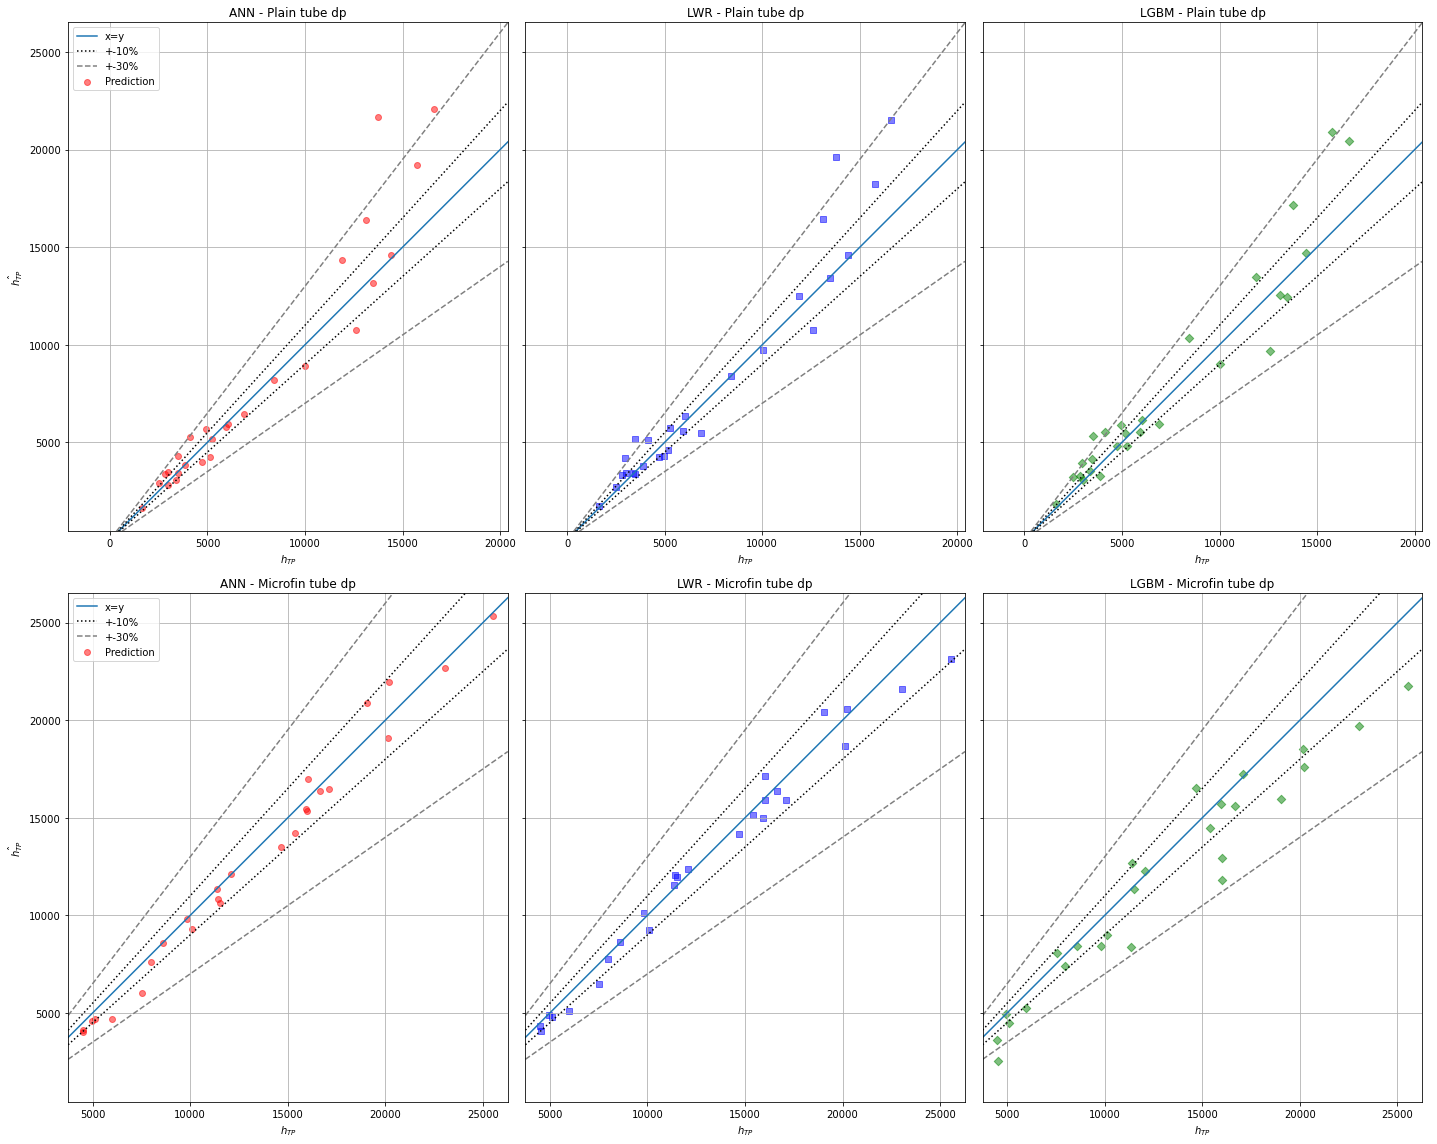

In [205]:
plot_predictions(data_dp, data_test, y_test, [y_pred1, y_pred2, y_pred3], ['ANN', 'LWR', 'LGBM'])

Eklenecek

# Extrapolation analysis

In this section, we demonstrate the selected models' strength for making accurate estimations outside observed ranges during the experiment.

Extrapolation performance analysis is conducted by following approach: clusters are identified in principal component space through fitting a Gaussian Mixture Model (GMM), and a Ledoit-Wolf (LW) covariance estimator is fitted separately to each identified cluster again in principal component space.

Samples to be used for extrapolation are then determined by Mahalanobis distance estimations coming from LW estimators fitted on each cluster. 10 samples with the highest Mahalanobis distance are then held out for test and the rest of the samples are used for training the models.

In [206]:
data_train, data_test, X_train, X_test, y_train, y_test, c_train, c_test = model_selection.train_test_split(
    data_h, 
    Xh, 
    yh, 
    clusters, 
    test_size=0.04, 
    random_state=42, 
    stratify=sample_category
    )

In [207]:
h_gm = mixture.GaussianMixture(n_components=3, n_init=100, init_params='k-means++', max_iter=1000, tol=1e-6, )
h_pca = pipeline.Pipeline([
    ('scaler', impute.SimpleImputer(strategy='mean')),
    ('imputer', preprocessing.StandardScaler()),
    ('pca', decomposition.PCA(n_components=3))
])
h_cluster_pipeline = pipeline.Pipeline([
    ("pca", h_pca),
    ("gm", h_gm)
])

In [208]:
from sklearn import covariance

In [209]:
gm_h = h_cluster_pipeline.fit_predict(Xh)
pca_h = h_cluster_pipeline[:1].fit_transform(Xh)[:, :2]

In [210]:
outlier_indices = []
for c in range(3):
    f = Xh[gm_h == c]
    zz = h_pca[:2].transform(f)
    maho = covariance.LedoitWolf().fit(zz).mahalanobis(zz)
    outlier_indices += pd.Series(maho, index=f.index).sort_values(ascending=False).head(10).index.tolist()
    
#     outlier_indices += pd.DataFrame(h_cluster_pipeline.predict_proba(Xh), index=Xh.index)[c].apply(np.log)[gm_h==c].sort_values().head(10).index.tolist()

In [218]:
X_train = Xh.drop(outlier_indices)
X_test = Xh.loc[outlier_indices]
y_train = yh.drop(outlier_indices)
y_test = yh.loc[outlier_indices]
data_train = data_h.drop(outlier_indices)
data_test = data_h.loc[outlier_indices]

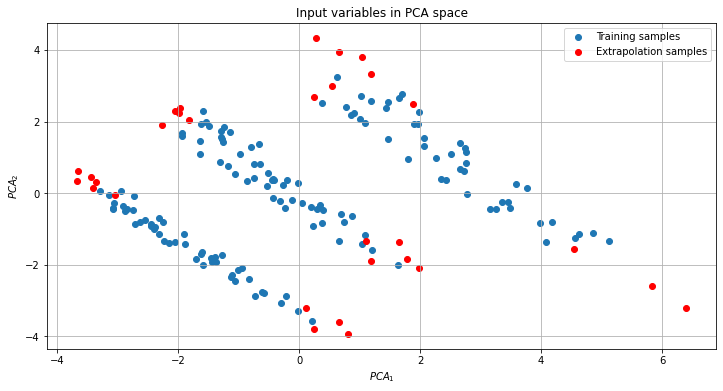

In [219]:
plt.figure(figsize=(12, 6))
plt.scatter(*h_cluster_pipeline[:1].transform(X_train)[:, :2].T, label='Training samples')
plt.scatter(*h_cluster_pipeline[:1].transform(X_test)[:, :2].T, color='red', label='Extrapolation samples')
plt.xlabel("$PCA_1$")
plt.ylabel("$PCA_2$")
plt.grid()
plt.legend()
plt.title("Input variables in PCA space");

Extrapolation samples identified using Mahalanobis distances are highlighted with red in figure. Note that these samples are located in the outermost of their respective distributions, and represent extreme input values.

In [220]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
pass

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [221]:
y_pred1 = model1.predict(X_test)
y_pred1 = pd.Series(y_pred1.ravel(), index=X_test.index)
y_pred2 = model2.predict(X_test)
y_pred2 = pd.Series(y_pred2.ravel(), index=X_test.index)
y_pred3 = model3.predict(X_test)
y_pred3 = pd.Series(y_pred3.ravel(), index=X_test.index)


In [222]:
scores1 = {}
scores2 = {}
scores3 = {}
for k, v in scoring.items():
    scores1[k] = v._score_func(y_test.values.ravel(), y_pred1, **v._kwargs)
    scores2[k] = v._score_func(y_test.values.ravel(), y_pred2, **v._kwargs)
    scores3[k] = v._score_func(y_test.values.ravel(), y_pred3, **v._kwargs)

In [223]:
final_scores_h_extra = pd.DataFrame([scores1, scores2, scores3], index=['ANN', 'LWR', 'LGBM'])

final_scores_h_extra

,R2,RMSE,MAE,MAPE,Bias%,WAPE%,Pearson-R
ANN,0.706914,800.301241,602.526495,0.105010,-0.024953,0.109056,0.746035
LWR,0.758915,725.841152,534.330825,0.089451,-0.061961,0.087985,0.818665
LGBM,0.504232,1040.867710,683.860666,0.107409,-0.100666,0.110083,0.695456


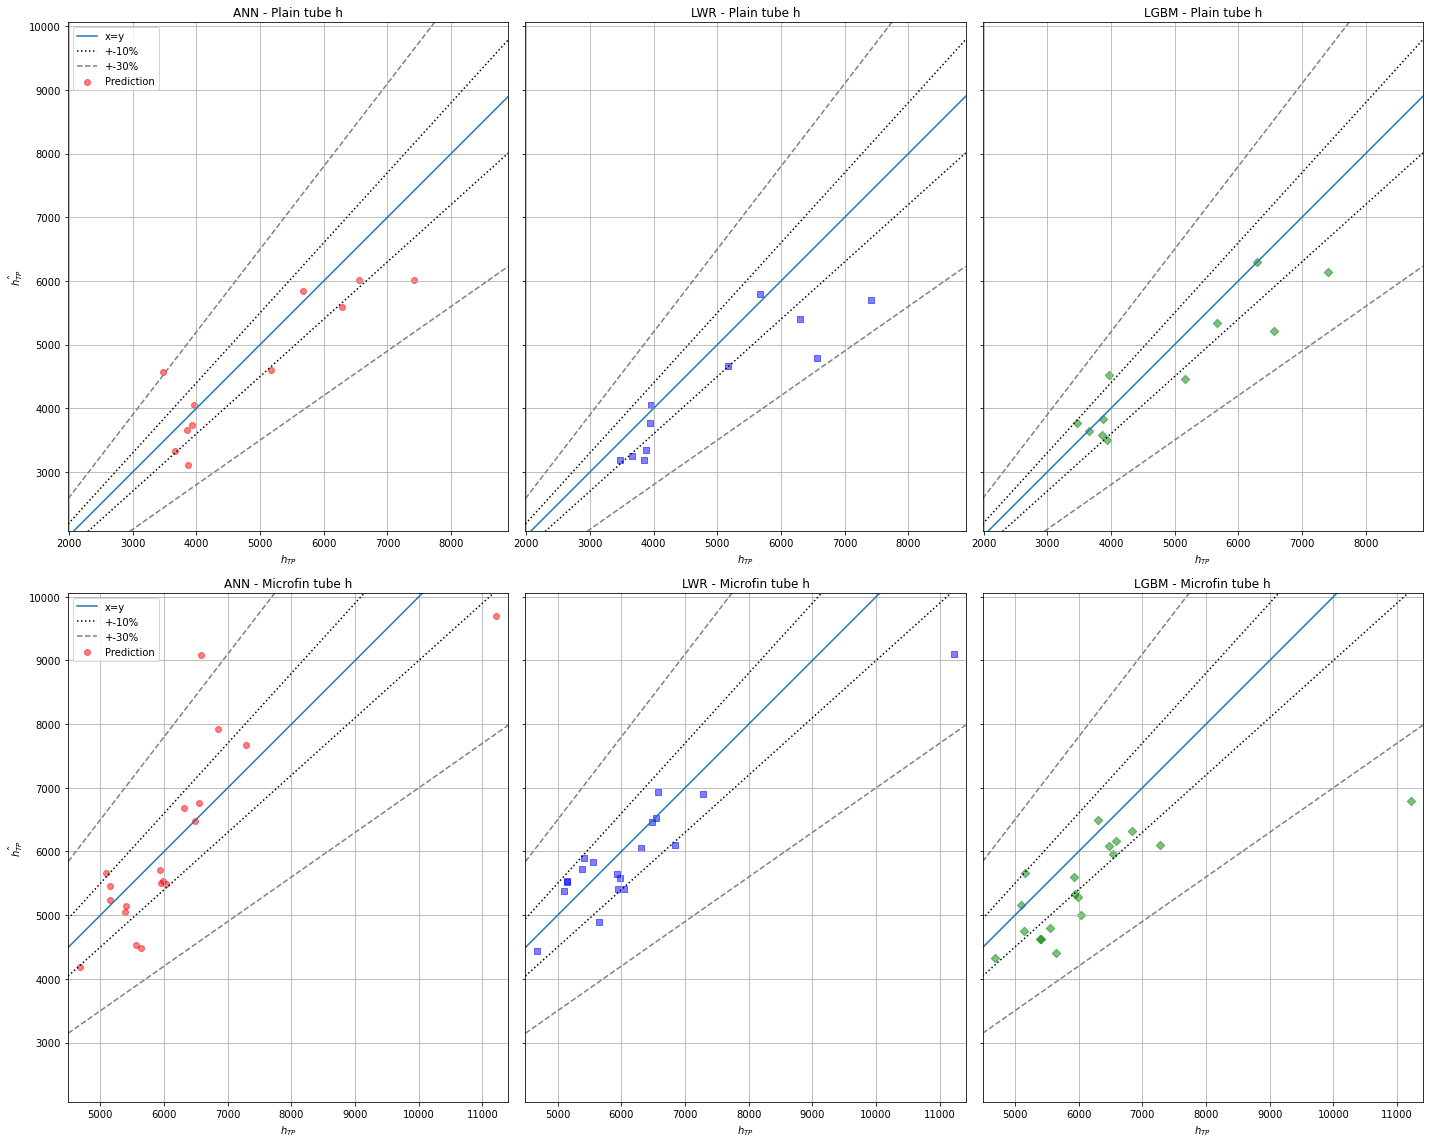

In [224]:
plot_predictions(data_h, data_test, y_test, [y_pred1, y_pred2, y_pred3], ['ANN', 'LWR', 'LGBM'])

Eklenecek

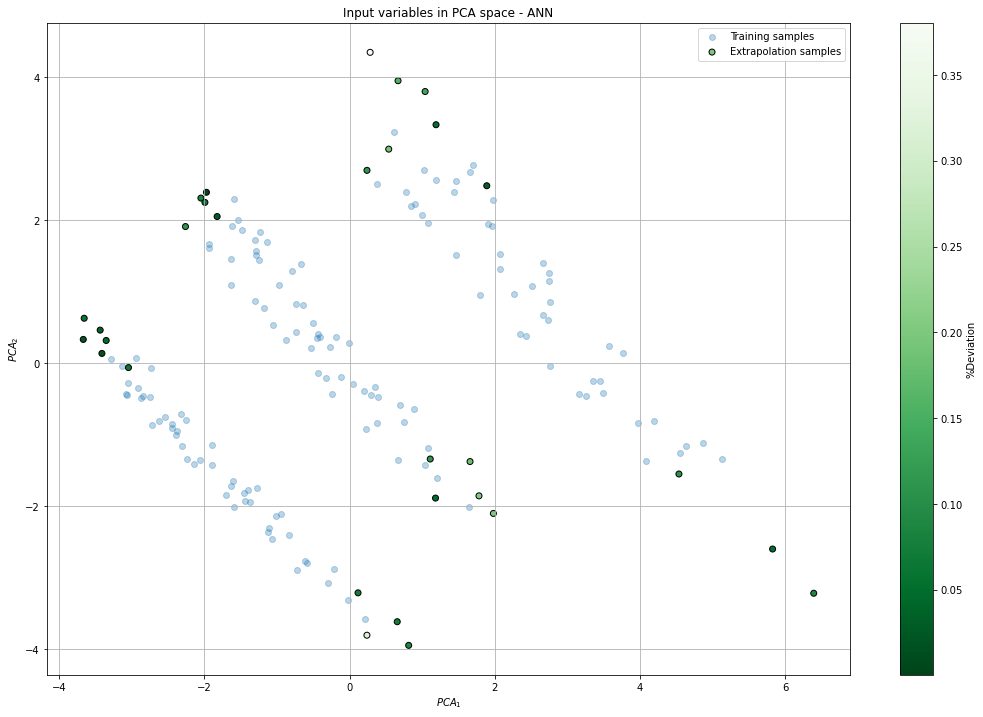

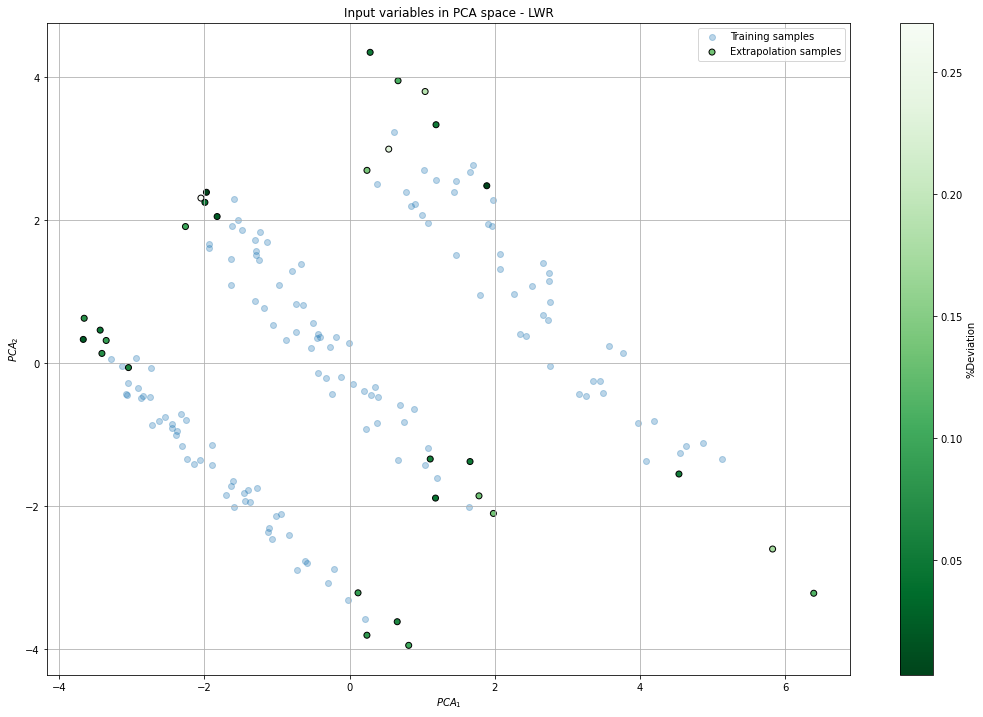

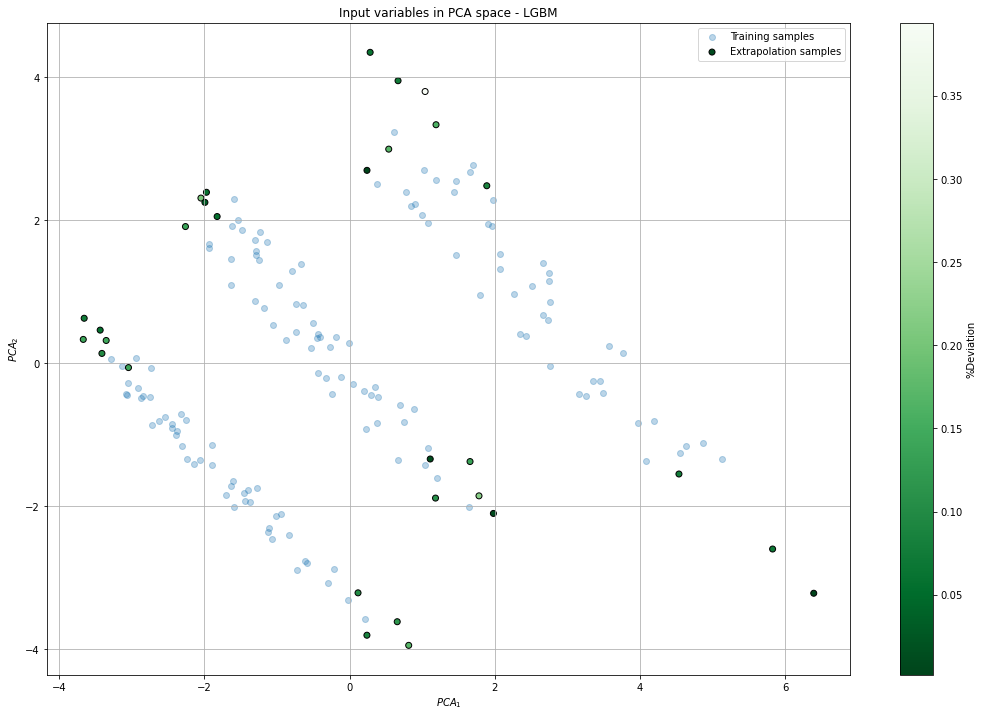

In [ ]:
for pred, naame in zip([y_pred1, y_pred2, y_pred3], ['ANN', 'LWR', 'LGBM']):
    deviations = np.abs(y_test.values.ravel() - pred.ravel()) / y_test.values.ravel()

    plt.figure(figsize=(18, 12))
    plt.scatter(*h_cluster_pipeline[:1].transform(X_train)[:, :2].T, label='Training samples', alpha=0.3)
    plt.scatter(*h_cluster_pipeline[:1].transform(X_test)[:, :2].T, c=deviations, label='Extrapolation samples', cmap='Greens_r', edgecolors='k')
    plt.xlabel("$PCA_1$")
    plt.ylabel("$PCA_2$")
    plt.grid()
    plt.legend()
    plt.colorbar().set_label("%Deviation")
    plt.title("Input variables in PCA space - " + naame);

Eklenecek

- Figurler ve tablolar word dosyasina eklenip aciklamalari yazilacak.
- 
